In [1]:
import mxnet as mx

from mxnet.symbol import Convolution, Activation, Pooling, Dropout, FullyConnected, var, flatten, SoftmaxOutput

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
mnist = mx.test_utils.get_mnist()

INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


In [3]:
batch_size = 64

train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist["train_label"], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist["test_label"], batch_size, shuffle=True)

In [4]:
def conv_layer(x, num_filter):
    
    x = Convolution(data=x, kernel=(5,5), num_filter=num_filter)
    x = Activation(data=x, act_type="tanh")
    x = Pooling(data=x, pool_type="max", kernel=(2,2), stride=(2,2))

    return x


def full_layers(x, architecture, act_type="tanh", p=None):
    
    for num_cell in architecture:
        x = FullyConnected(x, num_hidden=num_cell)
        if p is not None:
            x = Dropout(x, p=p)
        x = Activation(x, act_type=act_type)

    return x


def generate_lenet(dropout=None, act_type="tanh", full_geom=[500]):
    
    data = var("data")
    
    x = conv_layer(data, 20)
    x = conv_layer(x, 50)
    x = flatten(x)
    x = full_layers(x, full_geom, act_type=act_type, p=dropout)
    x = FullyConnected(data=x, num_hidden=10)
    x = SoftmaxOutput(data=x, name="softmax")
    
    return x, data

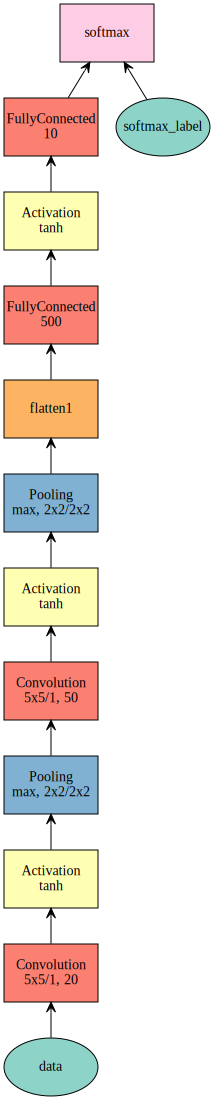

In [6]:
lenet, data = generate_lenet()

mx.viz.plot_network(lenet)

In [42]:
lenet_m = mx.mod.Module(lenet, context=mx.gpu())

sz = train_iter.data[0][1].shape

lenet_m.bind(data_shapes=[('data', (batch_size, sz[1], sz[2], sz[3]))],
             label_shapes=[('softmax_label', (batch_size,))])

lenet_m.init_params(mx.initializer.Xavier(magnitude=2.24))

lr_sch = mx.lr_scheduler.FactorScheduler(step=200, factor=0.995)
lenet_m.init_optimizer(
    optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ('lr_scheduler', lr_sch)))

In [43]:
lenet_m.fit(train_iter,
            eval_data=val_iter,
            num_epoch=20)

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Train-accuracy=0.693510
INFO:root:Epoch[0] Time cost=0.168
INFO:root:Epoch[0] Validation-accuracy=0.884355
INFO:root:Update[201]: Change learning rate to 9.95000e-02
INFO:root:Update[401]: Change learning rate to 9.90025e-02
INFO:root:Update[601]: Change learning rate to 9.85075e-02
INFO:root:Update[801]: Change learning rate to 9.80150e-02
INFO:root:Epoch[1] Train-accuracy=0.954807
INFO:root:Epoch[1] Time cost=2.501
INFO:root:Epoch[1] Validation-accuracy=0.981389
INFO:root:Update[1001]: Change learning rate to 9.75249e-02
INFO:root:Update[1201]: Change learning rate to 9.70373e-02
INFO:root:Update[1401]: Change learning rate to 9.65521e-02
INFO:root:Update[1601]: Change learning rate to 9.60693e-02
INFO:root:Update[1801]: Cha

INFO:root:Epoch[19] Validation-accuracy=0.991441
